In [12]:
# using Plots
using LinearAlgebra
using PyPlot

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

Main.PostProcess

In [13]:
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
ne = 10

ndim = 2
FunctionClass = "Q2";

In [14]:
function meshgrid(ne,FunctionClass,x0,x1,y0,y1,z0=nothing,z1=nothing)
    if !isnothing(y0) && !isnothing(y1)
        if FunctionClass == "Q1"
            x = collect(range(x0, x1, length=ne+1))
            y = collect(range(y0, y1, length=ne+1))
            
            NodeList = zeros(2,(ne+1)*(ne+1))
    
            k = 1
            for i in 1:ne+1
                for j in 1:ne+1
                    NodeList[1,k] = x[j]
                    NodeList[2,k] = y[i]
                    k = k + 1
                end
            end
    
            IEN = zeros(Int64,ne*ne,4)
            
            l = 1
            for i in 1:ne
                for j in 1:ne
                    IEN[l,1] = (i-1)*(ne+1) + j
                    IEN[l,2] = (i-1)*(ne+1) + j + 1
                    IEN[l,3] = i*(ne+1) + j + 1
                    IEN[l,4] = i*(ne+1) + j
                    l = l + 1
                end
            end
        elseif FunctionClass == "Q2"
            x = collect(range(x0, x1, length=2*ne+1))
            y = collect(range(y0, y1, length=2*ne+1))
            
            NodeList = zeros(2,(2*ne+1)*(2*ne+1))
    
            k = 1
            for i in 1:2*ne+1
                for j in 1:2*ne+1
                    NodeList[1,k] = x[j]
                    NodeList[2,k] = y[i]
                    k = k + 1
                end
            end
    
            IEN = zeros(Int64,ne*ne,9)
            
            l = 1
            for i in 1:ne
                for j in 1:ne
                    IEN[l,1] = 2*(i-1)*(2*ne+1) + 2*j - 1
                    IEN[l,2] = 2*(i-1)*(2*ne+1) + 2*j + 1
                    IEN[l,3] = 2*i*(2*ne+1) + 2*j + 1
                    IEN[l,4] = 2*i*(2*ne+1) + 2*j - 1
                    IEN[l,5] = 2*(i-1)*(2*ne+1) + 2*j
                    IEN[l,6] = (2*i-1)*(2*ne+1) + 2*j + 1
                    IEN[l,7] = 2*i*(2*ne+1) + 2*j
                    IEN[l,8] = (2*i-1)*(2*ne+1) + 2*j - 1
                    IEN[l,9] = (2*i-1)*(2*ne+1) + 2*j
                    l = l + 1
                end
            end 
        end
    end
    
    return NodeList, IEN
end

meshgrid (generic function with 3 methods)

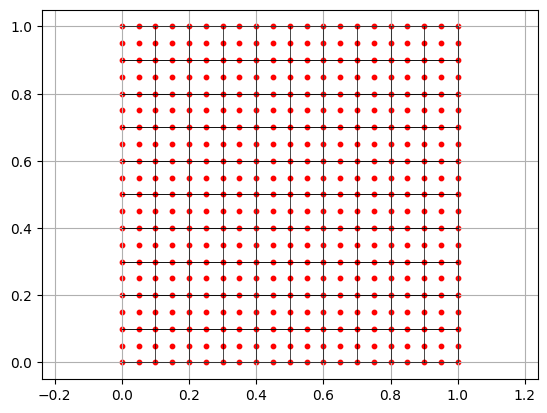

In [15]:
# set up mesh grid
NodeList, IEN = meshgrid(ne,FunctionClass,x0,x1,y0,y1)

fig1 = plt.figure()
ax = fig1.add_subplot(111)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,1:4]]
    y = NodeList[2,IEN[i,1:4]]
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.scatter(NodeList[1,:],NodeList[2,:],s=10,c="r")
ax.axis("equal")
ax.grid("on")

gcf()

In [16]:
function setboundaryCond(NodeList, ne, ndim, FunctionClass)
    # set dirichlet boundary conditions

    if FunctionClass == "Q1"
        q_d = zeros((ne+1)^ndim,1)
        q_n = zeros((ne+1)^ndim,1)

        C = Matrix{Int}(I,(ne+1)^ndim,(ne+1)^ndim) # definition of the constraint matrix

        C = C[:,((ne+1)^(ndim-1)+1):((ne+1)^ndim-(ne+1)^(ndim-1))]
    elseif FunctionClass == "Q2"
        q_d = zeros((2*ne+1)^ndim,1)
        q_n = zeros((2*ne+1)^ndim,1)

        C = Matrix{Int}(I,(2*ne+1)^ndim,(2*ne+1)^ndim) # definition of the constraint matrix
        C = C[:,((2*ne+1)^(ndim-1)+1):((2*ne+1)^ndim-(2*ne+1)^(ndim-1))]
    end

    Dbound1 = 0
    Dbound2 = 1
    Nbound = 0

    for n in 1:length(q_d)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[2] == Dbound1 # bottom boundary
            q_d[n] = 0
        elseif coord[2] == Dbound2 # top boundary
            q_d[n] = 1
        end

        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end
        
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim, FunctionClass);

In [17]:
K = fem.assemble_system(ne, NodeList, IEN, ndim, FunctionClass)

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim, FunctionClass);

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

In [18]:
function rearrange(q, ne, ndim, IEN, FunctionClass) 
    
    if FunctionClass == "Q1"
        return q, IEN
    elseif FunctionClass == "Q2"
        q_new = zeros((ne+1)^ndim,1)
        IEN_new = zeros(Int64,ne*ne,4)
        for i in 1:ne+1
            for j in 1:ne+1
                q_new[(i-1)*(ne+1)+j] = q[2*(i-1)*(2*ne+1) + (2*j-1)]
            end
        end

        for e in 1:ne*ne
            IEN_new[e,:] = IEN[e,1:4]
        end
        return q_new, IEN_new
    end
end

rearrange (generic function with 1 method)

In [19]:
q_new, IEN_new = rearrange(q, ne, ndim, IEN, FunctionClass);

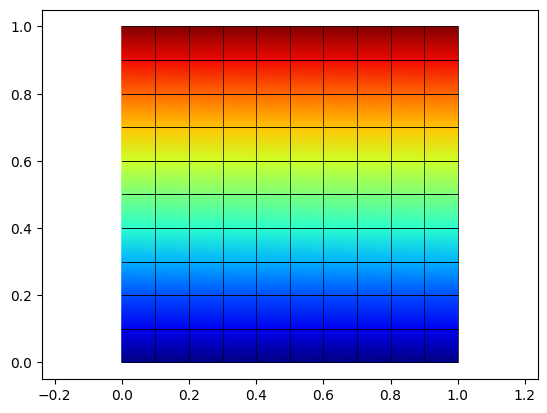

In [20]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
qList = PostProcess.noramlize(q, IEN_new)

for i in 1:size(IEN_new,1)
    x = NodeList[1,IEN_new[i,:]]
    y = NodeList[2,IEN_new[i,:]]
    c = qList[i,:]
    cmap = PostProcess.truncate_colormap(maximum(c), minimum(c))
    ax.tripcolor(x, y, c, cmap=cmap,shading="gouraud" )
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.axis("equal")
gcf()

In [21]:
PostProcess.write_vtk("vtkFiles/isoParam2dLagrange","u",NodeList,IEN_new, ne, ndim, q)

1-element Vector{String}:
 "vtkFiles/isoParam2dLagrange.vtu"